In [11]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import warnings
import multiprocessing
import ctypes as c
from datetime import datetime, time, timedelta
from scipy.interpolate import interp1d
from optparse import OptionParser
import xarray as xr
from contextlib import contextmanager
from scipy.spatial import cKDTree
from functools import partial
import time
import os

Rd = 287.0
Cp = 1004.0
p0 = 100000.0

In [13]:
###### SET FILE NAMES AND CONSTANTS ######
date = "ideal"
utc = 00  # Initailization Time
ng = 24  # Number of groups to compare (e.g., WRF & FV3)
ne = 1  # Number of ensemble members in each group of files
fstart = 15  # Forecast time start
fend = 360    # Forecast time end
nf = 24

#group_names = ('WRF_km4_dt15','FV3_dt20_hord6_q11','FV3_dt20_hord6_q12','FV3_dt20_hord6_q13','FV3_dt20_hord6_q14','FV3_dt20_hord6_q15','FV3_dt20_hord6_q16','CM1_q11','CM1_q12','CM1_q13','CM1_q14','CM1_q15','CM1_q16')  # Name of the groups to compare
group_names = ('WRF_qv11','WRF_qv12','WRF_qv13','WRF_qv14','WRF_qv15','WRF_qv16','FV3_dt20_hord6_q11','FV3_dt20_hord6_q12','FV3_dt20_hord6_q13','FV3_dt20_hord6_q14','FV3_dt20_hord6_q15','FV3_dt20_hord6_q16','FV3_C1000','FV3_C1500','FV3_C2000','FV3_C2500','FV3_C3000','FV3_C3500','CM1_q11','CM1_q12','CM1_q13','CM1_q14','CM1_q15','CM1_q16')
#group_names = ('CM1','')
#group_names_label = ('WRF','FV3_q11','FV3_q12','FV3_q13','FV3_q14','FV3_q15','FV3_q16','CM1_q11','CM1_q12','CM1_q13','CM1_q14','CM1_q15','CM1_q16')
group_names_label = ('WRF_qv11','WRF_qv12','WRF_qv13','WRF_qv14','WRF_qv15','WRF_qv16','FV3_q11','FV3_q12','FV3_q13','FV3_q14','FV3_q15','FV3_q16','FV3_C1000','FV3_C1500','FV3_C2000','FV3_C2500','FV3_C3000','FV3_C3500','CM1_q11','CM1_q12','CM1_q13','CM1_q14','CM1_q15','CM1_q16')
top_dir = "/scratch/larissa.reames/ideal_updrafts"
shear = "shallow_12.5"
#case_dir = "%s/%s"%(top_dir)
filter_top_dir = "/work/wicker/CAM_case_studies"
filter_case_dir = "%s/%s"%(filter_top_dir,date)

#filter_file_names = ''
#updraft_file_name = "%s/%s_track_data.nc"%(case_dir,date)
#fcst_type = 0
ens = 0
filter_lvls = [0]#,12,8]
nflt = 1
wths = [5.0,7.5]
dbzths = [45.0,55.0]
nth = 1

In [20]:
z_interp = np.arange(0.0,15000.0,250.0)
nz = z_interp.shape[0]
obj_sizes=np.full((ng,nth,nf,500),np.nan)
obj_counts=np.full((ng,nth,nf),np.nan)
for g in np.arange(ng):
    if 'FV3' in group_names[g] : 
        objmax = 500
    else:
        objmax = 200
    obj_x=np.full((nth,nf,500,250),np.nan)
    obj_y=np.full((nth,nf,500,250),np.nan)
    for th in np.arange(nth):
        wth = wths[th]
        dbzth = dbzths[th]
        updraft_file_name = "%s/%s_%s_track_data_noth_%2.1f_%02d.nc"%(top_dir,shear,group_names[g],wth,dbzth)
        print(updraft_file_name)
        fobj = xr.open_dataset(updraft_file_name)
        obj_x[th,:,:objmax,:] = fobj.OBJ_LOCS_X[:,:objmax,:250] #oth,time,obj,obj-point
        obj_y[th,:,:objmax,:] = fobj.OBJ_LOCS_Y[:,:objmax,:250]
        obj_sizes[g,th,:,:objmax] = (np.array(fobj.OBJ_SIZES[:,:objmax]))
        obj_counts[g,th,:] = (np.array(fobj.OBJ_COUNTS))
        
    obj_x = np.array(obj_x)
    obj_y = np.array(obj_y)
    for j,fl in enumerate(filter_lvls):
        print("Begin reading in data for group %s" % group_names[g])
        if (j > 0):
            #stream = os.popen("seq -f "+filter_case_dir+"/"+group_names[g].lower()+"/W_%02d"%(fl)+"/filtered_*_F%02g.nc"+" %02d %02d"%(fstart,fend))
            fs = glob.glob('%s/%s/W_%02d/filtered*.nc'%(filter_case_dir,group_names[g].lower(),fl))
        else:
            #stream = os.popen("seq -f "+case_dir+"/"+group_names[g].lower()+"/econus_"+date+"00_F%02g.nc"+" %02d %02d"%(fstart,fend))
            string = '%s/%s/%s/*'%(top_dir,group_names[g],shear)
            print(string)
            fs = glob.glob(string)
        #fs = []
        #for line in stream.readlines() :
        #    fs.append(line.strip())
        fs.sort()
        print(fs)
        for n,fname in enumerate(fs):
            print(fname)
            f = xr.open_dataset(fname)  
            if 'CM1' in group_names[g] :
                pres = f.prs0[0,:]+f.prspert[0,:]
                temp = f.th[0,:]* (pres/p0)**(Rd/Cp)
                vap = f.qv[0,:]
                rho = 0.622*pres/(Rd*temp*(vap+0.622))
                w = f.winterp[0,:]
                nz,ny,nx = np.shape(w)
                z = np.broadcast_to(f.zh,(nx,ny,nz)).transpose()*1000.0
                cond = (f.qc[0,:] + f.qr[0,:] + f.qi[0,:] + f.qs[0,:] + f.qg[0,:] + f.qhl[0,:])*rho
                vap = vap * rho
            else:
                wfull = f.W[0,:]
                w = (wfull[:-1,:] + wfull[1:,:])/2
                vap = f.QVAPOR[0,:]
                z = (f.PH[0,:]+f.PHB[0,:])/9.81 - f.HGT[0,:]
                z = (z[:-1,:] + z[1:,:])/2
                temp = f.T[0,:]+300.0
                pres = f.P[0,:]+f.PB[0,:]
                rho = 0.622*pres/(Rd*temp*(vap+0.622))
                if ('WRF' in group_names[g]):
                    cond = (f.QCLOUD[0,:] + f.QRAIN[0,:] + f.QICE[0,:] + f.QSNOW[0,:] + f.QGRAUP[0,:])*rho
                else :
                    cond = (f.QCLOUD[0,:] + f.QRAIN[0,:] + f.QICE[0,:] + f.QSNOW[0,:] + f.QGRAUP[0,:] + f.QHAIL[0,:])*rho
                vap = vap * rho

            nz_cur,_,_ = np.shape(w)
            if (n == 0 and j==0 and g==0):
                w_objs = np.full((ng,nth,nflt,nf,500,250,nz),np.nan)
                cond_objs = np.full((ng,nth,nflt,nf,500,250,nz),np.nan)
                vap_objs = np.full((ng,nth,nflt,nf,500,250,nz),np.nan)
                #obj_sizes = np.full((ng,3,nf,500),np.nan)

            for th in np.arange(nth):
                obj_x_cur = np.where(obj_x[th,n,...]<0,np.nan, obj_x[th,n,...])
                obj_y_cur = np.where(obj_y[th,n,...]<0,np.nan, obj_y[th,n,...])
                nobj = np.sum((~np.isnan(obj_x_cur[:,0])).astype(int))
                for i in np.arange(nobj):
                    obj_size = np.sum((~np.isnan(obj_x_cur[i,:])).astype(int))
                    #obj_sizes[g,j,n,i] = obj_size #ng,nflt,time,500
                    #if (obj_size > 20): continue
                    #print(obj_size)
                    w_interp = np.full(nz,0.0)
                    for p in np.arange(obj_size):
                        y = obj_y_cur[i,p].astype(int)
                        x = obj_x_cur[i,p].astype(int)
                        z_cur = z[:,y,x]
                        w_cur = w[:,y,x]
                        cond_cur = cond[:,y,x]
                        vap_cur = vap[:,y,x]
                        w_objs[g,th,j,n,i,p,:] = np.interp(z_interp,z_cur,w_cur )
                        cond_objs[g,th,j,n,i,p,:] = np.interp(z_interp,z_cur,cond_cur )
                        vap_objs[g,th,j,n,i,p,:] = np.interp(z_interp,z_cur,vap_cur )


/scratch/larissa.reames/ideal_updrafts/shallow_12.5_WRF_qv11_track_data_noth_5.0_45.nc
Begin reading in data for group WRF_qv11
/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/*
['/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_22:15:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_22:30:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_22:45:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_23:00:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_23:15:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_23:30:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-20_23:45:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11/shallow_12.5/wrfout_d01_2019-05-21_00:00:00', '/scratch/larissa.reames/ideal_updrafts/WRF_qv11

/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_01:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_01:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_01:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_02:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_02:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_02:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_02:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_03:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_03:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-21_03:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv12/shallow_12.5/wrfout_d01_2019-05-

/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_22:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_22:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_23:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_23:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_23:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-20_23:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-21_00:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-21_00:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-21_00:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-21_00:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv14/shallow_12.5/wrfout_d01_2019-05-

/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_22:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_22:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_23:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_23:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_23:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-20_23:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-21_00:00:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-21_00:15:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-21_00:30:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-21_00:45:00
/scratch/larissa.reames/ideal_updrafts/WRF_qv16/shallow_12.5/wrfout_d01_2019-05-

/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q12/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q

/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q14/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q

/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q16/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_dt20_hord6_q

/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C1500/shallow_12.5/woffv3_d01_2019-05-21_00:45:00.nc
/scratch/larissa.reames/ideal_updrafts/F

/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C2500/shallow_12.5/woffv3_d01_2019-05-21_00:45:00.nc
/scratch/larissa.reames/ideal_updrafts/F

/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_22:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_22:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_23:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_23:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_23:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-20_23:45:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-21_00:00:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-21_00:15:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-21_00:30:00.nc
/scratch/larissa.reames/ideal_updrafts/FV3_C3500/shallow_12.5/woffv3_d01_2019-05-21_00:45:00.nc
/scratch/larissa.reames/ideal_updrafts/F

/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000003.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000004.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000005.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000006.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000007.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000008.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000009.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000010.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000011.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000012.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000013.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000014.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q12/shallow_12.5/cm1out_000015.nc

/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000007.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000008.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000009.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000010.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000011.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000012.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000013.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000014.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000015.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000016.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000017.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000018.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q14/shallow_12.5/cm1out_000019.nc

/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000011.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000012.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000013.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000014.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000015.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000016.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000017.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000018.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000019.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000020.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000021.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000022.nc
/scratch/larissa.reames/ideal_updrafts/CM1_q16/shallow_12.5/cm1out_000023.nc

In [6]:
w_objs_2plus = np.copy(w_objs)
w_objs_3plus = np.copy(w_objs)
obj_sizes_2plus = np.copy(obj_sizes)
obj_sizes_3plus = np.copy(obj_sizes)
obj_counts_2plus = np.copy(obj_counts)
obj_counts_3plus = np.copy(obj_counts)
#[g,th,j,n,i,p,:]
for g in np.arange(3):
    for th in np.arange(2):
        for t in np.arange(6):
            np.where(obj_sizes_2plus[g,th,t,:]<2,np.nan,obj_sizes[g,th,t,:])
            np.where(obj_sizes_3plus[g,th,t,:]<3,np.nan,obj_sizes[g,th,t,:])
            nlt2 = np.count_nonzero(obj_sizes[g,th,t,:]<2)
            nlt3 = np.count_nonzero(obj_sizes[g,th,t,:]<3)
            obj_counts_2plus[g,th,t] -= nlt2 
            obj_counts_3plus[g,th,t] -= nlt3
            no = np.count_nonzero(~np.isnan(w_objs[g,th,0,t,:,0,0]))
            for i in np.arange(no):
                sz = np.count_nonzero(~np.isnan(w_objs[g,th,0,t,i,:,0]))
                print(sz)
                for flt in np.arange(1):                    
                    if (sz < 2): 
                        w_objs_2plus[g,th,flt,t,i,:,:] = np.nan
                        w_objs_3plus[g,th,flt,t,i,:,:] = np.nan
                        print("size less than 2 ", sz)
                    elif (sz < 3): 
                        w_objs_3plus[g,th,flt,t,i,:,:] = np.nan
                        print("size less than 3 ", sz)

9
9
8
8
8
9
8
11
10
11
10
12
12
12
8
2
size less than 3  2
11
18
2
size less than 3  2
20
2
size less than 3  2
17
2
size less than 3  2
20
1
size less than 2  1
23
18
2
size less than 3  2
13
8
2
size less than 3  2
10
10
9
9
9
9
7
20
11
12
1
size less than 2  1
12
15
37
34
27
33
38
40
1
size less than 2  1
17
1
size less than 2  1
5
5
5
5
6
6
4
9
8
8
8
8
7
10
6
5
3
5
3
3
4
4
5
1
size less than 2  1
5
5
5
4
4
8
6
6
6
5
5
6
7
5
7
6
8
6
8
8
26
20
20
21
24
27
10
9
7
7
6
7
8
8
12
9
11
10
1
size less than 2  1
12
13
13
11
1
size less than 2  1
9
22
6
10
6
11
6
5
5
2
size less than 3  2
5
7
10
17
1
size less than 2  1
1
size less than 2  1
8
13
8
9
9
7
12
1
size less than 2  1
6
22
1
size less than 2  1
13
15
1
size less than 2  1
14
1
size less than 2  1
19
4
1
size less than 2  1
46
1
size less than 2  1
42
1
size less than 2  1
41
2
size less than 3  2
2
size less than 3  2
1
size less than 2  1
40
28
2
size less than 3  2
3
40
1
size less than 2  1
6
18
5
3
3
3
4
6
4
10
6
8
7
9
8
6
9
6


11
5
12
6
273
136
459
229
684
342
859
429


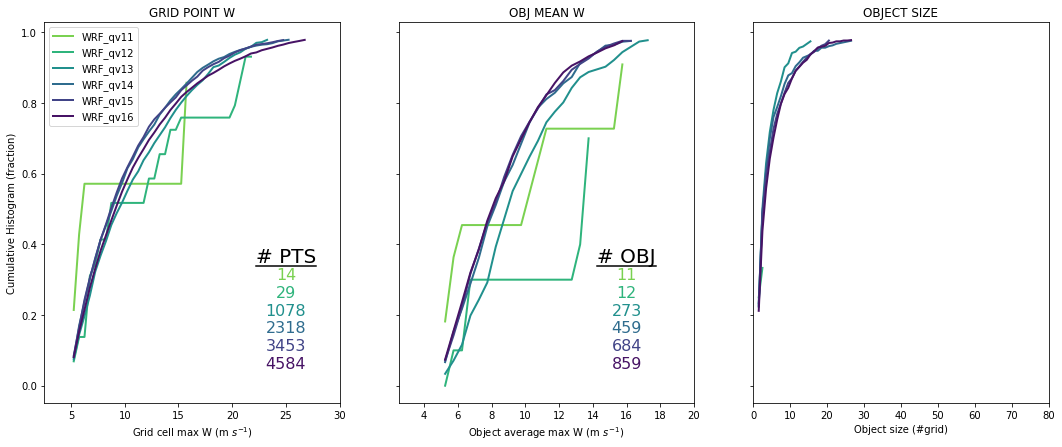

In [32]:
#print(np.nansum(obj_sizes))
#print(np.nansum(obj_sizes_2plus))
#print(np.nansum(obj_sizes_3plus))
ng_start = 0
ng_end = 6
cmap = matplotlib.cm.get_cmap('viridis_r')
#linecolors=(cmap(0.65),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95))
linecolors=(cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95),cmap(0.2),cmap(0.35),cmap(0.5),cmap(0.65),cmap(0.8),cmap(0.95))
#linestyles=("-","--","--","--","--","--","--",":","-")
linestyles=("-","-","-","-","-","-","--","--","--","--","--","--",":",":",":",":",":",":")
linewidths=np.full(24,2.0)
#w_objs[g,oth,j,n,i,p,:] group, oth, filter, time, obj, point, z
#w_pct = np.full((nth,ng,3),0.0)
for th in np.arange(nth):
    fig,ax = plt.subplots(1,3,sharey='row')
    fig.set_size_inches(18,7)
    wth = wths[th]
    dbzth = dbzths[th]
    #w_pts_plot = np.nanmax(w_objs[:,th,0,...].squeeze(),axis=4) #group, time, obj, point
    #w_pts_plot = w_pts_plot.reshape((ng,3000000))
    #w_obj_plot = np.nanmax(np.nanmean(w_objs[:,th,0,...].squeeze(),axis=3),axis=3).reshape(ng,12000)

    #edges = np.arange(wth,55.0,0.5)
    #obj_size_plot = obj_sizes[:,th,:,:].reshape((ng,12000))
    for g in np.arange(ng_start,ng_end): #(ng):
        print(np.sum((~np.isnan(w_obj_plot[g,:])).astype(int)))
        w_pct[th,g,:] = np.nanpercentile(w_obj_plot[g,:],(50,75,90))
        print(np.sum((w_obj_plot[g,~np.isnan(w_obj_plot[g,:])]>w_pct[th,g,0]).astype(int)))
        w_cur = w_pts_plot[g,:]
        hist = np.histogram(w_cur[~np.isnan(w_cur)],bins=edges)[0]
        #ng,nflt,time,500


        npts = np.nansum(obj_sizes[g,th,...])
        edges_size = np.arange(1,200,1)
            
        pct = np.cumsum(hist)/np.sum(hist)
        
        ax[0].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle='-',label='{}'.format(group_names_label[g]))
        ax[0].set_ylabel('Cumulative Histogram (fraction)')
        ax[0].set_xlabel('Grid cell max W (m $s^{-1}$)')
        if th ==0 : ax[0].set_xlim((2.5,30.0))
        if g==ng_start: 
            textx1 = 25.0 #edges[np.argmin(pct<0.98)]*.7
            pttitle=ax[0].text(textx1,0.35,'# PTS',fontsize=20,ha='center')
        ax[0].text(textx1,0.3-0.05*(g-ng_start),'%d'%npts,fontsize=16,color=linecolors[g],ha='center')
        ax[0].set_title('GRID POINT W')
        ax[0].legend()

        w_cur = w_obj_plot[g,:]
        nobjs = np.nansum(obj_counts[g,th,...])
        hist = np.histogram(w_cur[~np.isnan(w_cur)],bins=edges)[0] 
        pct = np.cumsum(hist)/np.sum(hist)
        textx = edges[np.argmin(pct<0.98)]/2
        ax[1].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle='-',label='{}'.format(group_names_label[g]))
        ax[1].set_xlabel('Object average max W (m $s^{-1}$)')
        if th == 0 : ax[1].set_xlim((2.5,20.0))
        if g==ng_start: 
            textx2 = 16.0 #edges[np.argmin(pct<0.98)]*.95
            objtitle=ax[1].text(textx2,0.35,'# OBJ',fontsize=20,ha='center')
            
        ax[1].text(textx2,0.3-0.05*(g-ng_start),'%d'%nobjs,fontsize=16,color=linecolors[g],ha='center')
        ax[1].set_title('OBJ MEAN W')

        size_cur = obj_size_plot[g,:]
        hist = np.histogram(size_cur[~np.isnan(size_cur)],bins=edges_size)[0] 
        pct = np.cumsum(hist)/np.sum(hist)
        if th == 0 : ax[2].set_xlim((0.0,80.0))
        ax[2].plot(edges_size[:np.argmin(pct<0.98)]+0.5,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle='-',label='{}'.format(group_names_label[g]))
        ax[2].set_xlabel('Object size (#grid)')
        ax[2].set_title('OBJECT SIZE')

    fig.canvas.draw()
    transf = ax[0].transData.inverted()
    bb = pttitle.get_window_extent()
    bb_datacoords = bb.transformed(transf)
    ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

    transf = ax[1].transData.inverted()
    bb = objtitle.get_window_extent()
    bb_datacoords = bb.transformed(transf)
    ax[1].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

    plt.show()
    fig.savefig('/scratch/larissa.reames/ideal_updrafts/%s_W%2.1fDBZ%02dobj_hist_wrf_qv.png'%(shear,wth,dbzth),dpi=300)

In [17]:
print(np.nanmean(w_obj_plot[5,:]))

0.018259450613182775


/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: Mean of empty slice
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))
/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: All-NaN slice encountered
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))


oth 0 WRF_qv11 W 50 pct = 10.47
oth 0 WRF_qv12 W 50 pct = 13.39
oth 0 WRF_qv13 W 50 pct = 9.09
oth 0 WRF_qv14 W 50 pct = 8.35
oth 0 WRF_qv15 W 50 pct = 8.21
oth 0 WRF_qv16 W 50 pct = 8.18
oth 0 FV3_dt20_hord6_q11 W 50 pct = 8.90
oth 0 FV3_dt20_hord6_q12 W 50 pct = 8.99
oth 0 FV3_dt20_hord6_q13 W 50 pct = 8.66
oth 0 FV3_dt20_hord6_q14 W 50 pct = 8.78
oth 0 FV3_dt20_hord6_q15 W 50 pct = 8.46
oth 0 FV3_dt20_hord6_q16 W 50 pct = 8.65
oth 0 FV3_C1000 W 50 pct = 6.56
oth 0 FV3_C1500 W 50 pct = 7.74
oth 0 FV3_C2000 W 50 pct = 6.58
oth 0 FV3_C2500 W 50 pct = 7.04
oth 0 FV3_C3000 W 50 pct = 7.27
oth 0 FV3_C3500 W 50 pct = 7.67
oth 0 CM1_q11 W 50 pct = 0.11
oth 0 CM1_q12 W 50 pct = 0.32
oth 0 CM1_q13 W 50 pct = 0.72
oth 0 CM1_q14 W 50 pct = 1.82
oth 0 CM1_q15 W 50 pct = 1.81
oth 0 CM1_q16 W 50 pct = 1.26


/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: Mean of empty slice
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))
/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: All-NaN slice encountered
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))


oth 0 WRF_qv11 W 75 pct = 13.44
oth 0 WRF_qv12 W 75 pct = 13.83
oth 0 WRF_qv13 W 75 pct = 11.46
oth 0 WRF_qv14 W 75 pct = 10.49
oth 0 WRF_qv15 W 75 pct = 10.40
oth 0 WRF_qv16 W 75 pct = 10.45
oth 0 FV3_dt20_hord6_q11 W 75 pct = 11.00
oth 0 FV3_dt20_hord6_q12 W 75 pct = 11.20
oth 0 FV3_dt20_hord6_q13 W 75 pct = 11.30
oth 0 FV3_dt20_hord6_q14 W 75 pct = 11.76
oth 0 FV3_dt20_hord6_q15 W 75 pct = 11.27
oth 0 FV3_dt20_hord6_q16 W 75 pct = 12.00
oth 0 FV3_C1000 W 75 pct = 7.73
oth 0 FV3_C1500 W 75 pct = 9.33
oth 0 FV3_C2000 W 75 pct = 8.67
oth 0 FV3_C2500 W 75 pct = 9.02
oth 0 FV3_C3000 W 75 pct = 9.48
oth 0 FV3_C3500 W 75 pct = 10.47
oth 0 CM1_q11 W 75 pct = 1.64
oth 0 CM1_q12 W 75 pct = 1.25
oth 0 CM1_q13 W 75 pct = 2.82
oth 0 CM1_q14 W 75 pct = 4.94
oth 0 CM1_q15 W 75 pct = 4.92
oth 0 CM1_q16 W 75 pct = 3.56


/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: Mean of empty slice
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))
/tmp/ipykernel_730485/2671800176.py:26: RuntimeWarning: All-NaN slice encountered
  w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))


oth 0 WRF_qv11 W 90 pct = 15.63
oth 0 WRF_qv12 W 90 pct = 14.34
oth 0 WRF_qv13 W 90 pct = 14.58
oth 0 WRF_qv14 W 90 pct = 13.26
oth 0 WRF_qv15 W 90 pct = 13.08
oth 0 WRF_qv16 W 90 pct = 12.89
oth 0 FV3_dt20_hord6_q11 W 90 pct = 12.96
oth 0 FV3_dt20_hord6_q12 W 90 pct = 13.83
oth 0 FV3_dt20_hord6_q13 W 90 pct = 13.84
oth 0 FV3_dt20_hord6_q14 W 90 pct = 14.24
oth 0 FV3_dt20_hord6_q15 W 90 pct = 14.77
oth 0 FV3_dt20_hord6_q16 W 90 pct = 16.32
oth 0 FV3_C1000 W 90 pct = 8.70
oth 0 FV3_C1500 W 90 pct = 10.78
oth 0 FV3_C2000 W 90 pct = 10.59
oth 0 FV3_C2500 W 90 pct = 11.72
oth 0 FV3_C3000 W 90 pct = 13.53
oth 0 FV3_C3500 W 90 pct = 13.40
oth 0 CM1_q11 W 90 pct = 8.96
oth 0 CM1_q12 W 90 pct = 4.34
oth 0 CM1_q13 W 90 pct = 6.19
oth 0 CM1_q14 W 90 pct = 7.79
oth 0 CM1_q15 W 90 pct = 7.92
oth 0 CM1_q16 W 90 pct = 6.80


"        \n        for i in np.arange(ng):\n            w_plot = np.nanmean(vap_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)\n            ax[1].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names_label[i]))\n            #ax[1].text(15.0,2000.0-500.0*i,'%i'%npts,color=linecolors[i],fontsize=14,ha='center')\n            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))\n\n        #ax[1].set_xlim((0.0,0.016))\n        ax[1].set_ylim((0,15000))\n        ax[1].set_ylabel('Height AGL (m)')\n        #ax[0,0].set_xticks(np.arange(0,60,step=12))\n        ax[1].set_xlabel('water vapor(kg $m^{-3}$)')\n        ax[1].set_title('WATER VAPOR',fontsize=titlefontsize)\n        \n        for i in np.arange(ng):\n            w_plot = np.nanmean(cond_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)\n            

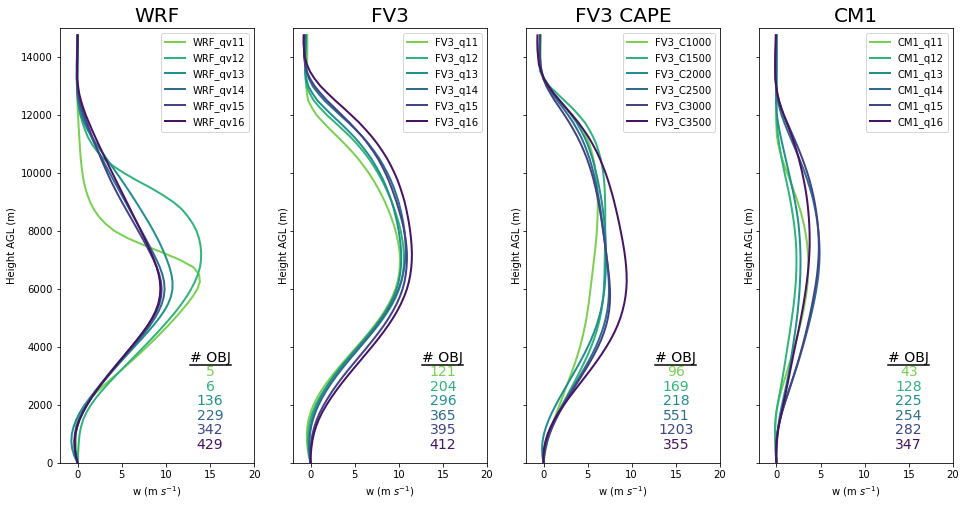

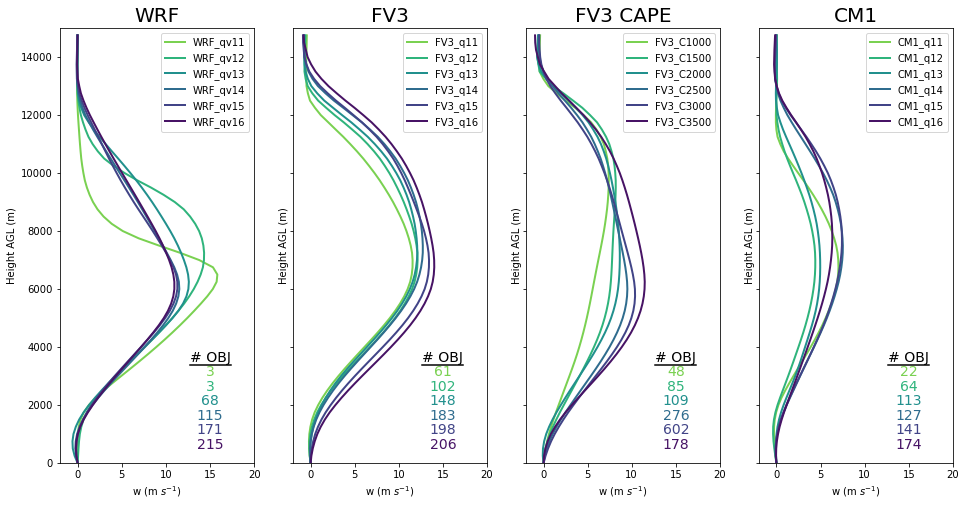

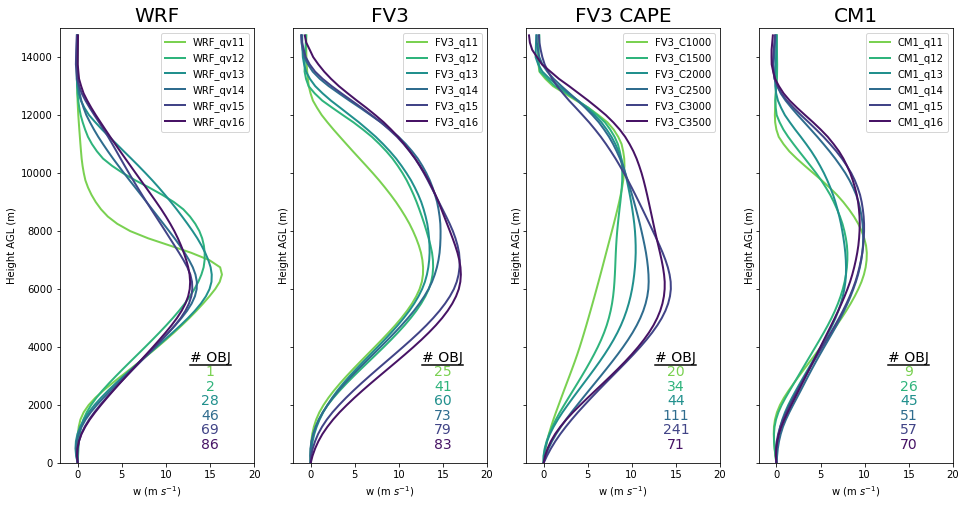

In [38]:
#linecolors=("black","xkcd:blue","xkcd:red")
#linestyles=("-","--","--")
#linewidths=(2,2,2,2)
#th = 2
#w_mean_all = np.stack((fobj.OBJ_W[:,th,...],w_mean_filter[:,1,th,...],w_mean_filter[:,0,th,...]))
#w_objs[g,j,n,i,p,:] group, oth,filter, time, obj, point, z (4, 3, 3, 6, 500, 300, 60)
#(4,3,6,500,60)
#(4,3,60,6,500)
#(4,3,60,3000) group,filter level,z,objects

threshes = [50,75,90]
titlefontsize=20
for oth in np.arange(nth):
    wth = wths[oth]
    dbzth = dbzths[oth]
    #w_obj_mean = np.reshape(np.moveaxis(np.nanmean(w_objs[:,oth,:,:,:,:,:],axis=4),4,2),(ng,1,nz,12000)) #group,flt,z, time*nobj
    #cond_obj_mean = np.reshape(np.moveaxis(np.nanmean(cond_objs[:,oth,:,:,:,:,:],axis=4),4,2),(ng,1,nz,12000))
    #vap_obj_mean = np.reshape(np.moveaxis(np.nanmean(vap_objs[:,oth,:,:,:,:,:],axis=4),4,2),(ng,1,nz,12000))
    for th in np.arange(3):
        fig,ax = plt.subplots(1,4,sharey='row')
        fig.set_size_inches(16,8)
        #z_interp = fobj.height
        #fig.subplots = plt.subplots_adjust(hspace=0.4, wspace=0.4)
        #fig.suptitle(title, fontsize=24)
        #group,time,object
        w_obj_max = np.reshape(np.nanmax(np.nanmean(w_objs[:,oth,0,...],3),3),(ng,12000))
        for i in np.arange(0,6):
            print('oth %d %s W %d pct = %4.2f'%(oth,group_names[i],threshes[th],w_pct[oth,i,th]))
            w_plot = np.nanmean(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            npts=np.shape(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]])[0]
            ax[0].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle='-',label='{}'.format(group_names_label[i]))
            ax[0].text(15.0,3000.0-500.0*i,'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        ax[0].set_xlim((-2.0,20.0))
        ax[0].set_ylim((0,15000))
        ax[0].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[0].set_xlabel('w (m $s^{-1}$)')
        ax[0].set_title('WRF',fontsize=titlefontsize)
        ax[0].legend()

        for i in np.arange(6,12):
            print('oth %d %s W %d pct = %4.2f'%(oth,group_names[i],threshes[th],w_pct[oth,i,th]))
            w_plot = np.nanmean(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            npts=np.shape(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]])[0]
            ax[1].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle='-',label='{}'.format(group_names_label[i]))
            ax[1].text(15.0,3000.0-500.0*(i-6),'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        ax[1].set_xlim((-2.0,20.0))
        ax[1].set_ylim((0,15000))
        ax[1].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[1].set_xlabel('w (m $s^{-1}$)')
        ax[1].set_title('FV3',fontsize=titlefontsize)
        ax[1].legend()
        
        
        
        for i in np.arange(12,18):
            print('oth %d %s W %d pct = %4.2f'%(oth,group_names[i],threshes[th],w_pct[oth,i,th]))
            w_plot = np.nanmean(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            npts=np.shape(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]])[0]
            ax[2].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle='-',label='{}'.format(group_names_label[i]))
            ax[2].text(15.0,3000.0-500.0*(i-12),'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        ax[2].set_xlim((-2.0,20.0))
        ax[2].set_ylim((0,15000))
        ax[2].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[2].set_xlabel('w (m $s^{-1}$)')
        ax[2].set_title('FV3 CAPE',fontsize=titlefontsize)
        ax[2].legend()
        
        for i in np.arange(18,24):
            print('oth %d %s W %d pct = %4.2f'%(oth,group_names[i],threshes[th],w_pct[oth,i,th]))
            w_plot = np.nanmean(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            npts=np.shape(w_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]])[0]
            ax[3].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle='-',label='{}'.format(group_names_label[i]))
            ax[3].text(15.0,3000.0-500.0*(i-18),'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        ax[3].set_xlim((-2.0,20.0))
        ax[3].set_ylim((0,15000))
        ax[3].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[3].set_xlabel('w (m $s^{-1}$)')
        ax[3].set_title('CM1',fontsize=titlefontsize)
        ax[3].legend()
        
        fig.canvas.draw()
        
        mytext = ax[0].text(15.0,3500.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[0].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
        
        mytext = ax[1].text(15.0,3500.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[1].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[1].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
        
        mytext = ax[2].text(15.0,3500.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[2].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[2].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
        
        mytext = ax[3].text(15.0,3500.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[3].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[3].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
        
        fig.savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_qv+cape.png'%(top_dir,shear,threshes[th],wth,dbzth),dpi=300)

'''        
        for i in np.arange(ng):
            w_plot = np.nanmean(vap_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            ax[1].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names_label[i]))
            #ax[1].text(15.0,2000.0-500.0*i,'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        #ax[1].set_xlim((0.0,0.016))
        ax[1].set_ylim((0,15000))
        ax[1].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[1].set_xlabel('water vapor(kg $m^{-3}$)')
        ax[1].set_title('WATER VAPOR',fontsize=titlefontsize)
        
        for i in np.arange(ng):
            w_plot = np.nanmean(cond_obj_mean[i,0,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            ax[2].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names_label[i]))
            #ax[2].text(15.0,2000.0-500.0*i,'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
            #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

        #ax[2].set_xlim((0,.01))
        ax[2].set_ylim((0,15000))
        ax[2].set_ylabel('Height AGL (m)')
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[2].set_xlabel('total condensate (kg $m^{-3}$)')
        ax[2].set_title('CONDENSATE',fontsize=titlefontsize)
        
            
        fig.canvas.draw()
        mytext = ax[0].text(15.0,3000.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[0].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))
      
        fig.savefig('%s/%s_%3.1f_W%2.1fDBZ%02dprofiles_qv.png'%(top_dir,shear,threshes[th],wth,dbzth),dpi=300)


        for i in np.arange(0,ng):
            w_plot = np.nanmean(w_obj_mean[i,1,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            ax[1].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

        ax[1].set_xlim((-2.0,22.0))
        ax[1].set_ylim((0,15000))
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[1].set_xlabel('w 12$\Delta$x filter (m $s^{-1}$)')
        ax[1].set_title('12$\Delta$X FILTER',fontsize=titlefontsize)
        
        for i in np.arange(0,ng):
            w_plot = np.nanmean(w_obj_mean[i,2,:,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)
            ax[2].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

        ax[2].set_xlim((-2.0,22.0))
        ax[2].set_ylim((0,15000))
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[2].set_xlabel('w 8$\Delta$x filter (m $s^{-1}$)')
        ax[2].set_title('8$\Delta$X FILTER',fontsize=titlefontsize)


        for i in np.arange(0,ng):
            ax[3].plot(np.nanmean(w_obj_mean[i,1,9:50,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0)/np.nanmean(w_obj_mean[i,0,9:50,w_obj_max[i,:]>w_pct[oth,i,th]],axis=0),z_interp[9:50],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

        ax[3].set_xlim((0.1,0.8))
        ax[3].set_ylim((0,15000))
        #ax[0,0].set_xticks(np.arange(0,60,step=12))
        ax[3].set_xlabel('w 8$\Delta$x filter remaining (frac)')
        ax[3].set_title('$\dfrac{8\Delta X}{UNFILTERED}$',fontsize=titlefontsize-4)

        fig.canvas.draw()
        mytext = ax[0].text(15.0,2500.0,'# OBJ',fontsize=14,ha='center')
        transf = ax[0].transData.inverted()
        bb = mytext.get_window_extent()
        bb_datacoords = bb.transformed(transf)
        ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

'''


In [20]:
print(w_pct)

[[[ 7.00549846  8.72898281 10.62480748]
  [ 8.36790828 10.50147091 13.34996316]
  [ 8.62048476 11.10224798 13.99438024]]

 [[10.63000503 13.1206195  15.88249237]
  [12.06522191 15.08593599 17.18932438]
  [12.37397798 16.1267126  19.8383007 ]]]
